# Covid-19 infección en Ecuador. Modelos matemáticos y predicciones
Una comparación de modelos, lineal, polilnomico,logísticos y exponenciales aplicados a la infección por el virus Covid-19

Se realiza un análisis matemático simple del crecimiento de la infección en Python y dos modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de curva.

In [27]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline


In [35]:
# Actualizar los datos (URL)

url = 'http://cowid.netlify.com/data/full_data.csv'

df = pd.read_csv(url)
df

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2020-02-25,Afghanistan,NaN,NaN,1,NaN
1,2020-02-26,Afghanistan,0.0,NaN,1,NaN
2,2020-02-27,Afghanistan,0.0,NaN,1,NaN
3,2020-02-28,Afghanistan,0.0,NaN,1,NaN
4,2020-02-29,Afghanistan,0.0,NaN,1,NaN
5,2020-03-01,Afghanistan,0.0,NaN,1,NaN
6,2020-03-02,Afghanistan,0.0,NaN,1,NaN
7,2020-03-03,Afghanistan,0.0,NaN,1,NaN
8,2020-03-04,Afghanistan,0.0,NaN,1,NaN
9,2020-03-05,Afghanistan,0.0,NaN,1,NaN


Imprimos los resultados y agregamos el numero del dia


In [29]:
df = df[df['location'].isin(['Ecuador'])] #Filtro la Informacion solo para Ecuador
df = df.loc[:,['date','total_cases']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)

df

,date,total_cases
681,60,1
682,61,1
683,62,6
684,63,7
685,64,7
686,65,13
687,66,14
688,67,14
689,68,15
690,69,15


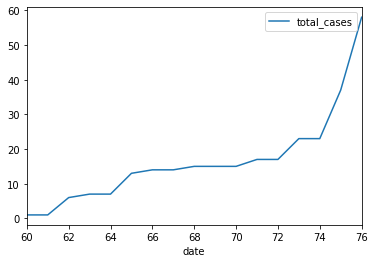

In [30]:
df.plot(x ='date', y='total_cases')

Ahora podemos analizar los cuatro modelos que tomaré en el examen, que son la función lineal, polinomica,logística y la función exponencial . Cada modelo tiene tres parámetros , que se estimarán mediante un cálculo de ajuste de curva en los datos históricos.

## EL modelo lineal

La regresión lineal es un algoritmo de aprendizaje supervisado que se utiliza en Machine Learning y en estadística. En su versión más sencilla, lo que haremos es «dibujar una recta» que nos indicará la tendencia de un conjunto de datos continuos.

Recordemos rápidamente la fórmula de la recta:

Y = mX + b

Donde Y es el resultado, X es la variable, m la pendiente (o coeficiente) de la recta y b la constante o también conocida como el «punto de corte con el eje Y» en la gráfica (cuando X=0)
Ejemplo
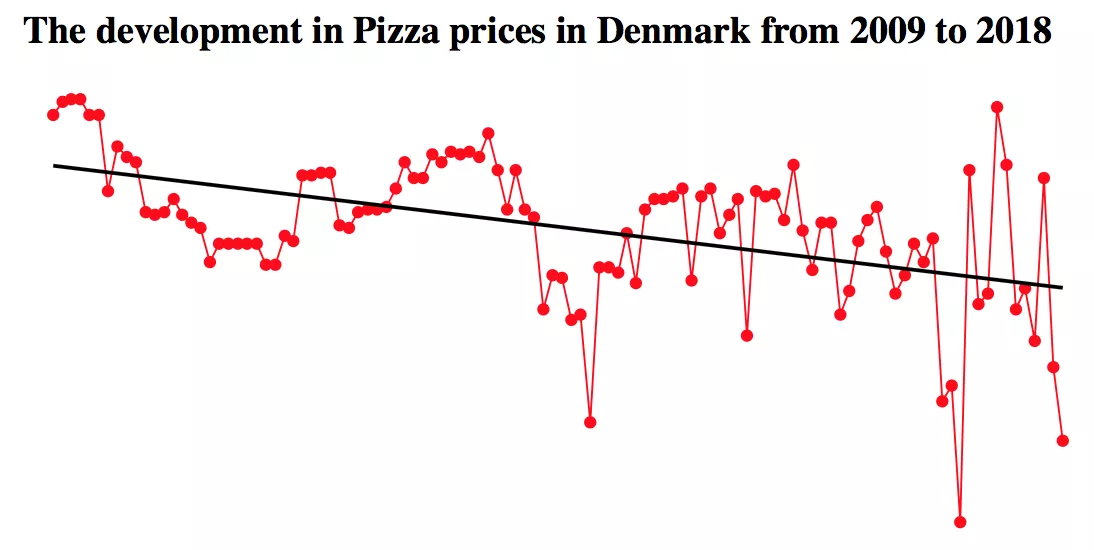

Recordemos que los algoritmos de Machine Learning Supervisados, aprenden por sí mismos y -en este caso- a obtener automáticamente esa «recta» que buscamos con la tendencia de predicción. Para hacerlo se mide el error con respecto a los puntos de entrada y el valor «Y» de salida real.



In [14]:
x = list(df.iloc [:, 0]) # Fecha
y = list(df.iloc [:, 1]) # Numero de casos
# Creamos el objeto de Regresión Lineal
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(np.array(x).reshape(-1, 1) ,y)

# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio

Coefficients: 
 [2.31617647]
Independent term: 
 -140.85294117647058


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [16]:
#Vamos a comprobar:
# Quiero predecir cuántos "Casos" voy a obtener por en el dia 100,
# según nuestro modelo, hacemos:
y_prediccion = regr.predict([[100]])
print(int(y_prediccion))

90


[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]


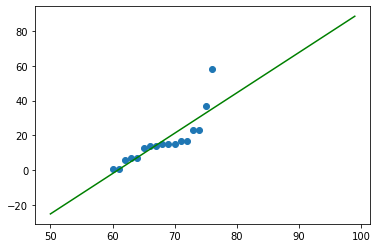

In [21]:
#Graficar
plt.scatter(x, y)
x_real = np.array(range(50, 100))
print(x_real)
plt.plot(x_real, regr.predict(x_real.reshape(-1, 1)), color='green')
plt.show()



## El modelo logistico

El modelo logístico se ha utilizado ampliamente para describir el crecimiento de una población. Una infección puede describirse como el crecimiento de la población de un agente patógeno, por lo que un modelo logístico parece razonable .
La expresión más genérica de una función logística es:

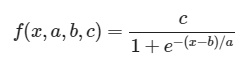

En esta fórmula, tenemos la variable x que es el tiempo y tres parámetros: a, b, c .

- a se refiere a la velocidad de infección
- b es el día en que ocurrieron las infecciones máximas
- c es el número total de personas infectadas registradas al final de la infección
 


A continuacion se puede apreciar un ejemplo de regresion logistica
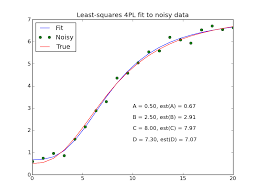

Definamos la función en Python y realicemos elprocedimiento de ajuste de curva utilizado para el crecimiento logístico.

In [31]:
def modelo_logistico(x,a,b):
    return a+b*np.log(x)

exp_fit = curve_fit(modelo_logistico,x,y) #Extraemos los valores de los paramatros
print(exp_fit)


(array([-637.69367899,  155.1710206 ]), array([[11872.54041468, -2814.63865054],
       [-2814.63865054,   667.4662425 ]]))


## Graficas

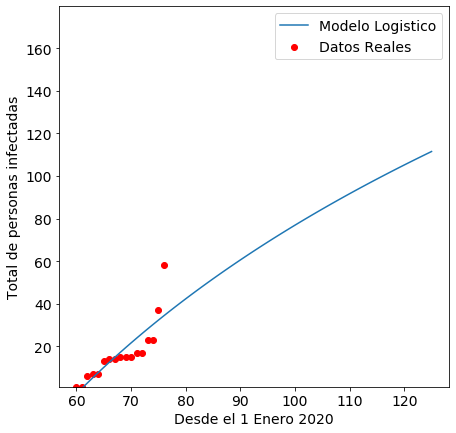

In [34]:
pred_x = list(range(min(x),max(x)+50)) # Predecir 50 dias mas
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Datos Reales",color="red")
# Predicted exponential curve
plt.plot(pred_x, [modelo_logistico(i,exp_fit[0][0],exp_fit[0][1]) for i in pred_x], label="Modelo Logistico" )
plt.legend()
plt.xlabel("Desde el 1 Enero 2020")
plt.ylabel("Total de personas infectadas")
plt.ylim((min(y)*0.9,max(y)*3.1)) # Definir los limites de Y
plt.show()

## Modelo exponencial

Mientras que el modelo logístico describe un crecimiento de infección que se detendrá en el futuro, el modelo exponencial describe un crecimiento de infección imparable . Por ejemplo, si un paciente infecta a 2 pacientes por día, después de 1 día tendremos 2 infecciones, 4 después de 2 días, 8 después de 3 y así sucesivamente.
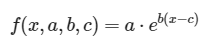

A continuacion se tiene un ejemplo de regresion exponencial
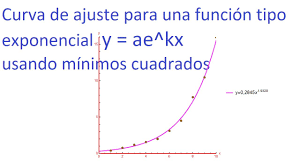

In [ ]:
# Implementar

## Modelo polinomial
Predicción de una variable de respuesta cuantitativa a partir de una variable predictora cuantitativa, donde la relación se modela como una función polinomial de orden n (esto significa que pueden tener de diferentes exponenciales o grados y se debe ir probando)  

Se puede tener una ecuacion con diferentes grados

y = a0 + a1x + a2x^2 + a3x^3 + … + anx^n + ε

Ejemplo de una regresion polinomica de grado 4.
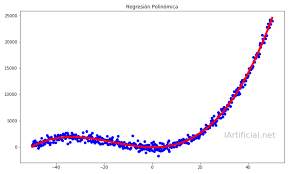


# REGRESIÓN LINEAL CON SKLEARN

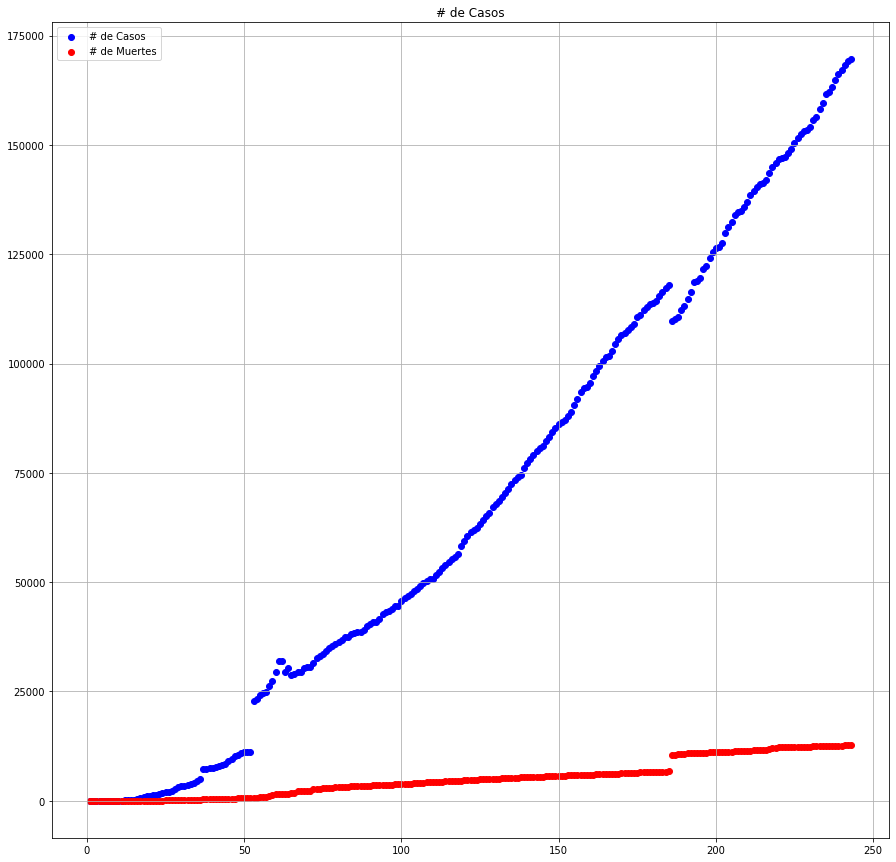

In [23]:
# Implementar Covid-19 Regresión Lineal
import numpy as np #Librería numérica
import matplotlib.pyplot as plt # Para crear gráficos con matplotlib
#%matplotlib inline # Si quieres hacer estos gráficos dentro de un jupyter notebook
from sklearn.linear_model import LinearRegression #Regresión Lineal con scikit-learn
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
%matplotlib inline

def f(x):  # función f(x) = 0.1*x + 1.25 + 0.2*Ruido_Gaussiano
    np.random.seed(42) # para poder reproducirlo
    y = 0.1*x + 1.25 + 0.2*np.random.randn(x.shape[0])
    return y

df = pd.read_csv('owid-covid-data.csv').fillna(0) # poniendo datos nan a cero
ndf= df.loc[(df['location'] == 'Ecuador') & (df['total_cases'] != 0)] # filtrando por pais y no ceros 
ndf1=ndf[['date','total_cases','total_deaths']]
x=np.arange(1,len(ndf1)+1,1) # arreglo de x lo creo para simular el numero del dia y el numero de casos
y=np.array(ndf1.values[:,1])
y1=np.array(ndf1.values[:,2])
#y=ndf1.values # calculamos y a partir de la función que hemos generado
# hacemos un gráfico de los datos que hemos generado
plt.figure(figsize=(15, 15))
plt.scatter(x,y,label='# de Casos', color='blue')
plt.scatter(x,y1,label='# de Muertes', color='red')
plt.grid(True)
plt.legend()
plt.title('# de Casos');
# Se puede implementar modelos adicionales, en caso de ser asi explicar o dar una introduccion del modelo aplicado

# Se tomara como puntos adicionales al trabajo.


In [24]:
regresion_lineal = LinearRegression() # creamos una instancia de LinearRegression
# instruimos a la regresión lineal que aprenda de los datos (x,y)
regresion_lineal.fit(x.reshape(-1,1), y) 
# vemos los parámetros que ha estimado la regresión lineal
print('w = ' + str(regresion_lineal.coef_[0]) + ', b = ' + str(regresion_lineal.intercept_))
# resultado: w = [0.09183522], b = 1.2858792525736682
if (regresion_lineal.intercept_ < 0):
    ecua='y = {}x {}'
else:
    ecua='y = {}x + {}'
print(ecua.format(regresion_lineal.coef_[0],regresion_lineal.intercept_))

w = 729.6465842394807, b = -19722.37710437714
y = 729.6465842394807x -19722.37710437714


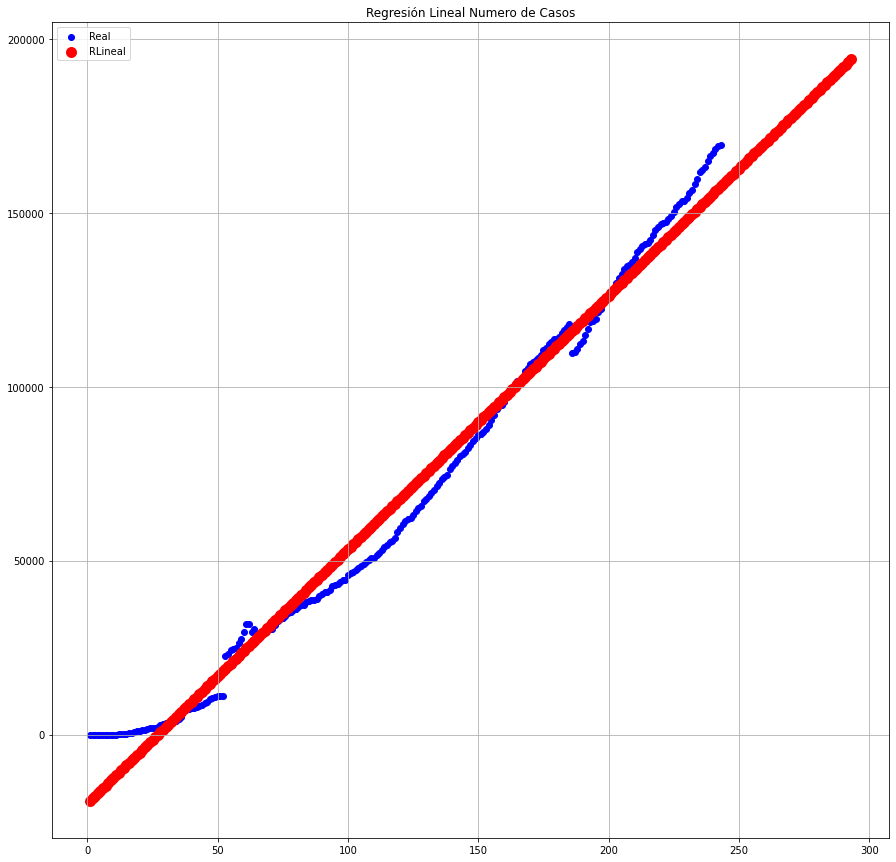

In [25]:
fun= lambda num: regresion_lineal.coef_[0]*num+regresion_lineal.intercept_
plt.figure(figsize=(15, 15))
plt.scatter(x,y,label='Real', color='blue')
plt.grid(True)
plt.title('Regresión Lineal Numero de Casos');
x1=np.arange(1,len(ndf1)+51,1)
plt.scatter(x1,fun(x1),color='red',linewidth=5.0,label='RLineal')
plt.legend()
plt.show()

In [26]:
regresion_lineal = LinearRegression() # creamos una instancia de LinearRegression
# instruimos a la regresión lineal que aprenda de los datos (x,y)
regresion_lineal.fit(x.reshape(-1,1), y1) 
# vemos los parámetros que ha estimado la regresión lineal
print('w = ' + str(regresion_lineal.coef_[0]) + ', b = ' + str(regresion_lineal.intercept_))
# resultado: w = [0.09183522], b = 1.2858792525736682
print(ecua.format(regresion_lineal.coef_[0],regresion_lineal.intercept_))

w = 57.82225634386593, b = -1818.9531340339481
y = 57.82225634386593x -1818.9531340339481


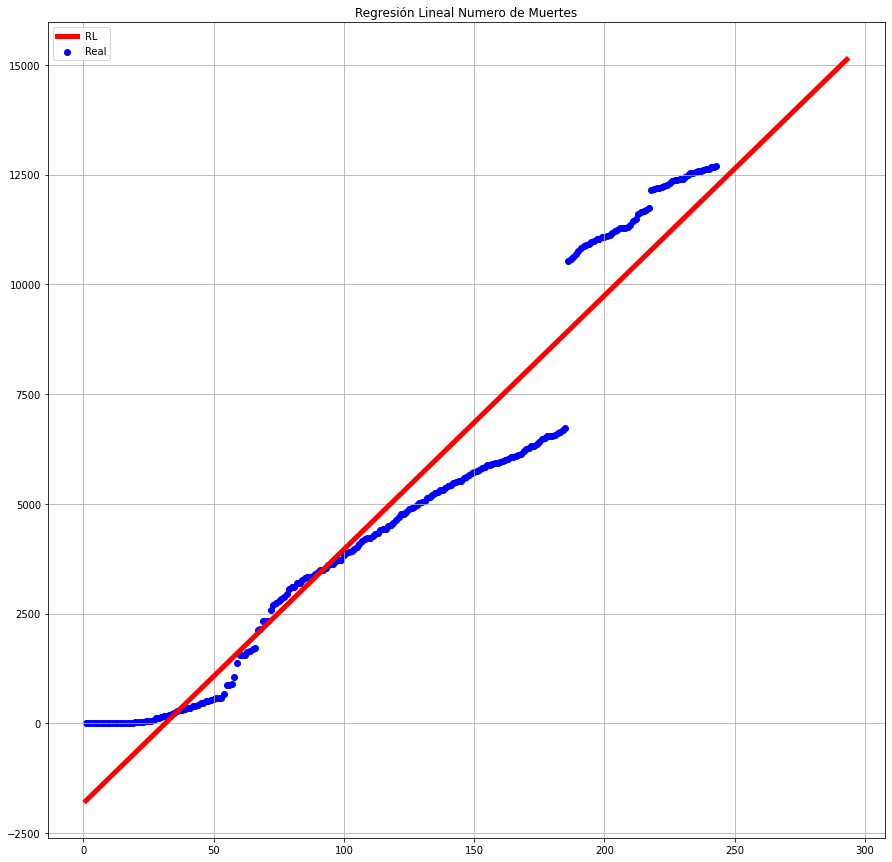

In [27]:
fun= lambda num: regresion_lineal.coef_[0]*num+regresion_lineal.intercept_
plt.figure(figsize=(15, 15))
plt.scatter(x,y1,label='Real', color='blue')
plt.grid(True)
plt.title('Regresión Lineal Numero de Muertes');
x2 = np.arange(1,len(ndf1)+51,1)
plt.plot(x2,fun(x2),color='red',linewidth=5.0,label='RL')
plt.legend()
plt.show()

# REGRESION LOGARITMICA

In [9]:
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegression
def modelo_logistico(x,a,b):
    return a+b*np.log(x)

exp_fit = curve_fit(modelo_logistico,x,y) #Extraemos los valores de los paramatros
exp_fit1 = curve_fit(modelo_logistico,x,y1) #Extraemos los valores de los paramatros

print(exp_fit)
print("")
print(exp_fit1)

(array([-132282.15628488,   44713.86100596]), array([[ 79233323.69668128, -16815968.22047479],
       [-16815968.22047479,   3730128.57348377]]))

(array([-10481.82124408,   3486.39542592]), array([[ 604709.26516529, -128339.5842676 ],
       [-128339.5842676 ,   28468.36684504]]))


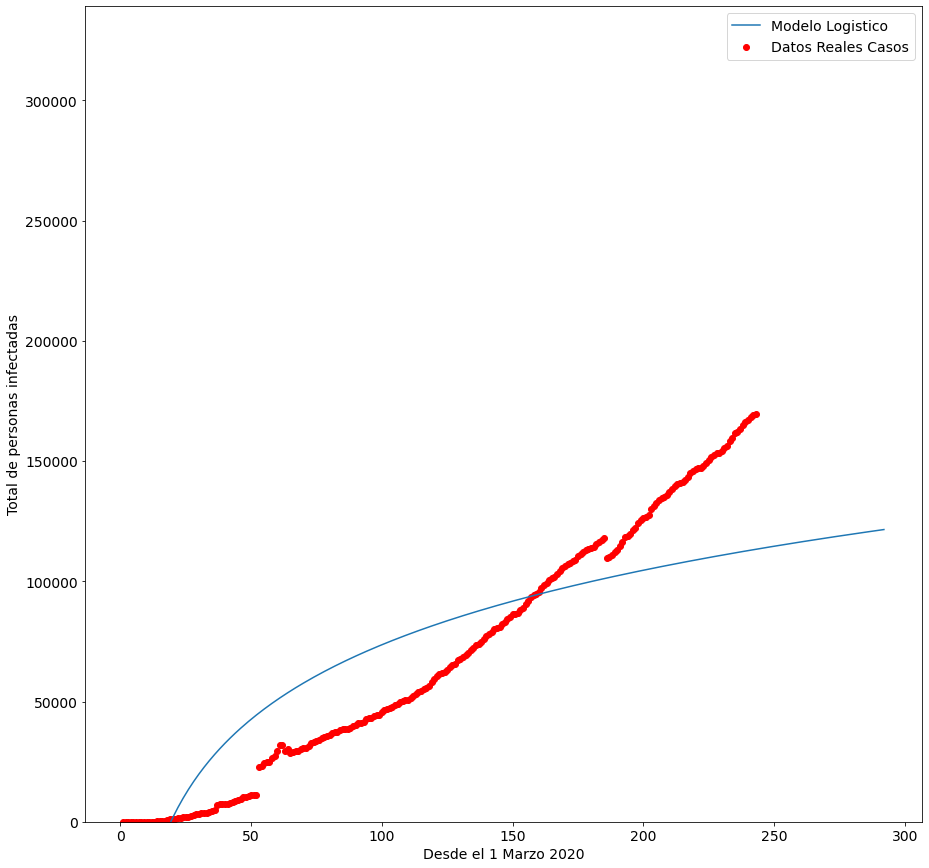

In [10]:
pred_x = list(range(min(x),max(x)+50)) # Predecir 50 dias mas
plt.rcParams['figure.figsize'] = [15, 15]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Datos Reales Casos",color="red")
# Predicted exponential curve
plt.plot(pred_x, [modelo_logistico(i,exp_fit[0][0],exp_fit[0][1]) for i in pred_x], label="Modelo Logistico" )
plt.legend()
plt.xlabel("Desde el 1 Marzo 2020")
plt.ylabel("Total de personas infectadas")
plt.ylim(0,max(y)*2) # Definir los limites de Y
plt.show()

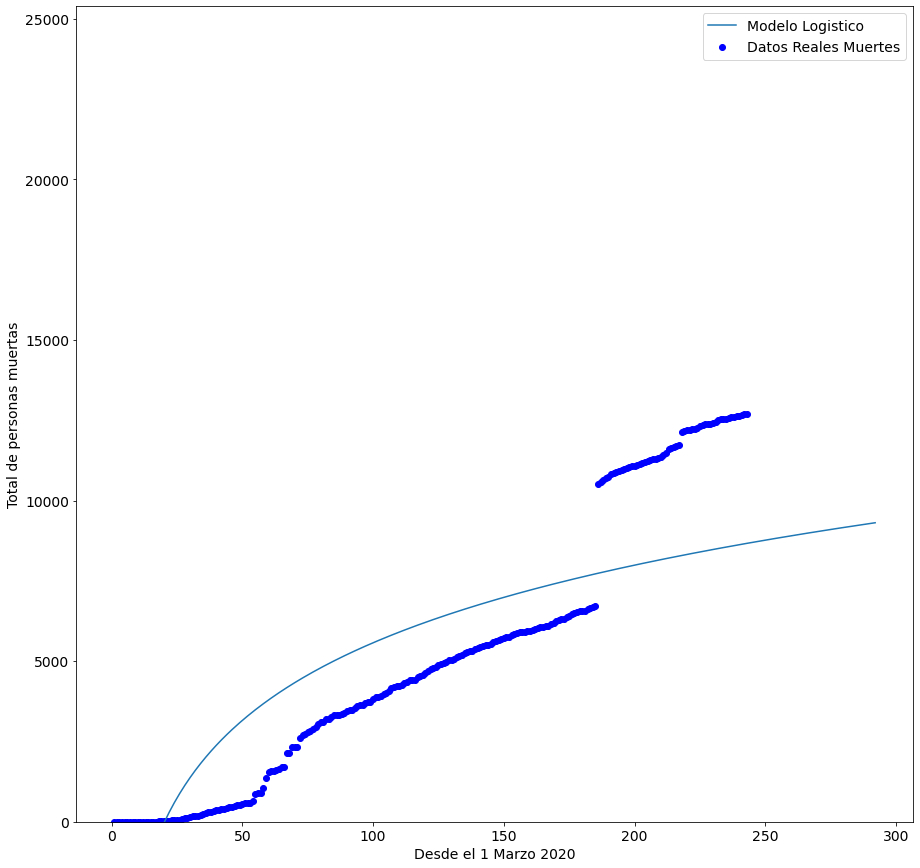

In [11]:
plt.scatter(x,y1,label="Datos Reales Muertes",color="blue")
plt.plot(pred_x, [modelo_logistico(i,exp_fit1[0][0],exp_fit1[0][1]) for i in pred_x], label="Modelo Logistico" )
plt.legend()
plt.xlabel("Desde el 1 Marzo 2020")
plt.ylabel("Total de personas muertas")
plt.ylim(0,max(y1)*2) # Definir los limites de Y
plt.show()

## Análisis
Para mi en este caso el que mejor resultado ha dado es la Regresión Lineal, llegando a describir de mejor forma el problema en cuestión. La Regresión Logaritmica esta muy lejos de representar los valores.

## Conclusiones
Las regresiones son metodos que nos ayudan muchisimo a simular la relación entre distintas variables. las mismas que tienen diferentes tipos y cada tipo se puede aplicar a diferentes tipos de problemas cada una de las cuales se adapta mejor a ciertos problemas y no a otros. Todo depende de que se quiere hacer.

## Criterio personal (politico, economico y  social de la situacion)
A mi punto de vista la administración del país no tenia las capacidades para soportar la pandemia del Covid-19, por lo cual se pueden ver los resultados actuales, además que las personas no cumplen las reglas establecidas adecuadamente emeoran la situación en cuestión.


# Referencias

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/